# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [15]:
# Standard libraries  
import os  # Provides functions for interacting with the operating system (e.g., file handling)  
import datetime  # Handles date and time operations  
import zipfile  # Works with ZIP archives (compression, extraction)  
import numpy as np  # Supports numerical computations and array operations  
import cv2  # OpenCV library for image processing and computer vision tasks   
import matplotlib.pyplot as plt  # Used for plotting graphs and visualizing images  
from skimage.io import imread  # Reads images from files  
from skimage.transform import resize  # Resizes images while maintaining aspect ratio  

We set the random seed so that the results don't vary drastically.

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [18]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
# Experiment with different batch sizes (e.g., 16, 32, 64)
batch_size = 32

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [19]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0, 30, 2))[:15]
    
    while True:
        t = np.random.permutation(folder_list)  # Shuffle folder list
        num_batches = len(folder_list) // batch_size  # Calculate number of batches
        
        for batch in range(num_batches):  # Iterate over batches
            batch_data = np.zeros((batch_size, len(img_idx), 120, 120, 3))  # Fixed size (180x180)
            batch_labels = np.zeros((batch_size, 5))  # One-hot encoding for 5 classes
            
            for folder in range(batch_size):  # Iterate over batch_size
                imgs = sorted(os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0]))
                
                for idx, item in enumerate(img_idx):  # Iterate over frames
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    image = resize(image, (120, 120))  # Resize image
                    image = image / 255.0  # Normalize image
                    
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]
                    
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1  # Assign label
                
            yield batch_data, batch_labels  # Yield batch data and labels
        
        remaining_data = len(folder_list) % batch_size  # Process remaining data
        if remaining_data > 0:
            batch_data = np.zeros((remaining_data, len(img_idx), 120, 120, 3))
            batch_labels = np.zeros((remaining_data, 5))
            
            for folder in range(remaining_data):
                imgs = sorted(os.listdir(source_path + '/' + t[num_batches * batch_size + folder].split(';')[0]))
                
                for idx, item in enumerate(img_idx):
                    image = imread(source_path + '/' + t[num_batches * batch_size + folder].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    image = resize(image, (120, 120))
                    image = image / 255.0
                    
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]
                    
                batch_labels[folder, int(t[num_batches * batch_size + folder].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels


#### ___The above generator function:___

- Selects 30 frames per video (img_idx).
- Resizes images to a fixed (180X180) shape.
- Normalizes pixel values between 0 and 1.
- Implements batch processing and handles remaining data after full batches.

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [20]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


In [21]:
# Import necessary modules from Keras for deep learning model building
from keras.models import Sequential, Model  # Sequential (linear stack), Model (functional API)

# Import various types of layers for feature extraction & learning
from keras.layers import (
    Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, BatchNormalization, 
    Activation, Input, Rescaling, GlobalAveragePooling1D, Conv2D, MaxPooling2D, 
    Conv3D, MaxPooling3D, GlobalAveragePooling3D, GlobalAveragePooling2D, 
    Bidirectional, ConvLSTM2D  # Supports RNNs with CNNs
)

# Import callbacks for training optimization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Import optimizers for adjusting learning rates
from tensorflow.keras.optimizers import Adam

# Import additional utilities for model optimization & regularization
from keras import optimizers, regularizers
from tensorflow.keras.regularizers import l2  # L2 regularization to prevent overfitting
from tensorflow.keras.regularizers import l1_l2  # L1 & L2 regularization

# Import Sequential model for simple layer stacking
from tensorflow.keras.models import Sequential

# Import layers explicitly to avoid redundancy
from tensorflow.keras import layers
from tensorflow.keras.layers import Reshape

# Import ReduceLROnPlateau callback to reduce learning rate when training plateaus
from tensorflow.keras.callbacks import ReduceLROnPlateau


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.0001) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Initial Models
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [25]:
# Model Configuration
input_shape = (15, 120, 120, 3) # ensure that your model correctly expects input with 15 frames per sequence, each of shape (180, 180, 3).
num_classes = 5

### ___Model 1___

In [12]:
# Define model
model = Sequential([
    
    Input(shape=input_shape),  # (frames, height, width, channels)

    # 1st Conv3D Layer
    Conv3D(8, (3,3,3), activation='relu', padding='same'),
    MaxPooling3D((2,2,2)),

    # 2nd Conv3D Layer
    Conv3D(16, (3,3,3), activation='relu', padding='same'),
    MaxPooling3D((2,2,2)),

    # 3rd Conv3D Layer
    Conv3D(32, (3,3,3), activation='relu', padding='same'),
    MaxPooling3D((2,2,1)),  # Reduce spatial dimensions while preserving temporal depth

    # Fully Connected Layers
    Flatten(),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # 5 classes for gesture classification
])

2025-03-12 06:43:39.308821: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-03-12 06:43:39.309076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22855 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [13]:
#optimiser
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 8)   656       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 8)     0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 16)     3472      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 30, 30, 16)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 30, 30, 32)     13856     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 15, 30, 32)    0

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
history1 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=LR, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/25


2025-03-12 06:43:45.720133: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - 116s 6s/step - loss: 1.6192 - categorical_accuracy: 0.2112 - val_loss: 1.5558 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - 108s 5s/step - loss: 1.5016 - categorical_accuracy: 0.3032 - val_loss: 1.3992 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - 82s 4s/step - loss: 1.1500 - categorical_accuracy: 0.5460 - val_loss: 0.9455 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 4/25
21/21 [==============================] - 78s 4s/step - loss: 0.8419 - categorical_accuracy: 0.6591 - val_loss: 0.9625 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 5/25
21/21 [==============================] - 80s 4s/step - loss: 0.6524 - categorical_accuracy: 0.7285 - val_loss: 0.8831 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 6/25
21/21 [==============================] - 83s 4s/step - loss: 0.5130 - categorical_accuracy: 0.8175 - val_loss: 0.

In [32]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy & loss over epochs.

    Parameters:
        history (tensorflow.keras.callbacks.History): The history object from model training.
    """
    acc = history.history.get('categorical_accuracy', [])
    val_acc = history.history.get('val_categorical_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training vs Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training vs Validation Loss')

    plt.tight_layout()
    plt.show()

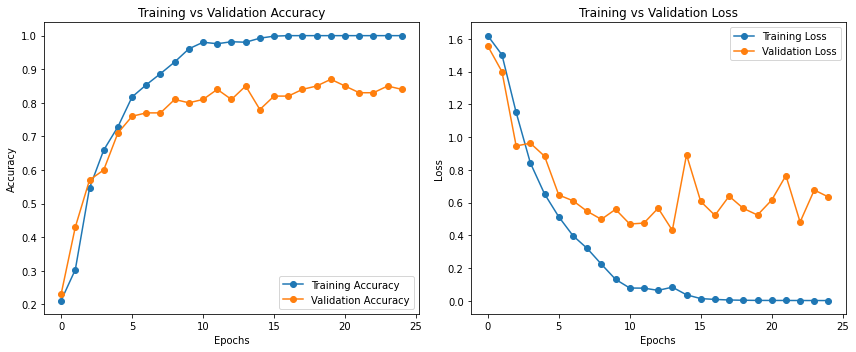

In [16]:
plot_training_history(history1)

### ___Model 2___

In [17]:
# Model Architecture
model = Sequential([
    # First 3D Convolutional Block
    Conv3D(8, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape, padding='same'),
    MaxPooling3D(pool_size=(1, 2, 2)),
    
    # Second 3D Convolutional Block
    Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(1, 2, 2)),
    
    # Third 3D Convolutional Block
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(1, 2, 2)),
    
    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    
    # Output Layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 120, 120, 8)   656       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 15, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 30, 30, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 30, 30, 32)    13856     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 15, 15, 15, 32)  

In [18]:
history2 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=LR, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
21/21 [==============================] - 85s 4s/step - loss: 1.6382 - categorical_accuracy: 0.2202 - val_loss: 1.5703 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - 84s 4s/step - loss: 1.4998 - categorical_accuracy: 0.2986 - val_loss: 1.3221 - val_categorical_accuracy: 0.5100 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - 78s 4s/step - loss: 1.2252 - categorical_accuracy: 0.5008 - val_loss: 1.0788 - val_categorical_accuracy: 0.5500 - lr: 0.0010
Epoch 4/25
21/21 [==============================] - 80s 4s/step - loss: 0.9685 - categorical_accuracy: 0.5973 - val_loss: 0.8774 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 5/25
21/21 [==============================] - 79s 4s/step - loss: 0.7463 - categorical_accuracy: 0.7164 - val_loss: 0.7979 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 6/25
21/21 [==============================] - 83s 4s/step - loss: 0.5761 - categorical_accuracy: 0.7768 - val

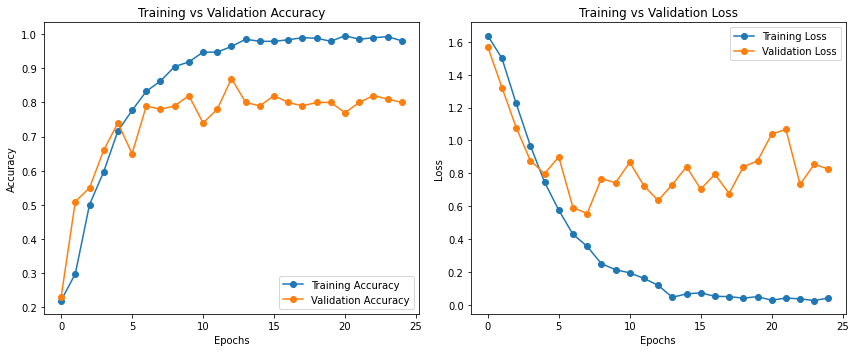

In [19]:
plot_training_history(history2)

### ___Model 3___

In [20]:
# Model Architecture
model = Sequential([

    # First 3D Convolutional Block
    Conv3D(8, kernel_size=(5, 5, 5), activation='relu', padding='same', kernel_regularizer=l1_l2(1e-5, 1e-4),input_shape=input_shape),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    # Second 3D Convolutional Block
    Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l1_l2(1e-5, 1e-4)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    # Third 3D Convolutional Block
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l1_l2(1e-5, 1e-4)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.1),

    # Global Average Pooling instead of Flatten
    GlobalAveragePooling3D(),
    
    Dense(64, activation='relu',kernel_regularizer=l1_l2(1e-5, 1e-4)),
    Dropout(0.5),
    Dense(32, activation='relu',kernel_regularizer=l1_l2(1e-5, 1e-4)),
    
    # Output Layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

# Reduce Learning Rate on Plateau
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.0001)

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 120, 120, 8)   3008      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 60, 60, 8)     0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 60, 60, 16)     3472      
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 3, 30, 30, 16)    0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 3, 30, 30, 32)     13856     
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 1, 15, 15, 32)   

In [21]:
history3 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=LR, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
21/21 [==============================] - 80s 4s/step - loss: 1.5657 - categorical_accuracy: 0.3077 - val_loss: 1.8080 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - 77s 4s/step - loss: 1.4208 - categorical_accuracy: 0.4359 - val_loss: 1.7155 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - 80s 4s/step - loss: 1.2426 - categorical_accuracy: 0.5023 - val_loss: 1.5705 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 4/25
21/21 [==============================] - 79s 4s/step - loss: 1.0762 - categorical_accuracy: 0.5551 - val_loss: 1.6395 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 5/25
21/21 [==============================] - 85s 4s/step - loss: 0.9840 - categorical_accuracy: 0.5928 - val_loss: 1.4109 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 6/25
21/21 [==============================] - 75s 4s/step - loss: 0.8967 - categorical_accuracy: 0.6410 - val

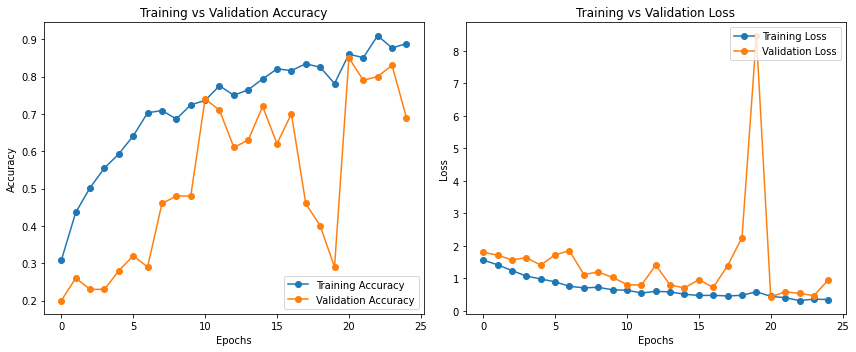

In [22]:
plot_training_history(history3)

### ___Model 4___

In [23]:
# Define the augmentation model
frame_augmentation  = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Flip images horizontally
    layers.RandomRotation(0.5),       # Increase random rotation
    layers.RandomZoom(0.5),           # Increase random zoom
],name="data_augmentation")

In [24]:
# Model Architecture
model = Sequential([
    
    # Apply augmentation to input frames (before 3D convolutions)
    layers.TimeDistributed(frame_augmentation, input_shape=input_shape),
    
    # First 3D Convolutional Block
    Conv3D(8, kernel_size=(5, 5, 5), activation='relu', padding='same', kernel_regularizer=l2(1e-3)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    # Second 3D Convolutional Block
    Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(1e-3)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    # Third 3D Convolutional Block
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(1e-3)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    # Global Average Pooling instead of Flatten
    GlobalAveragePooling3D(),
    
    Dense(64, activation='relu',kernel_regularizer=l2(1e-3)),
    Dropout(0.5),
    Dense(32, activation='relu',kernel_regularizer=l2(1e-3)),
    
    # Output Layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

# Reduce Learning Rate on Plateau
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.0001)

# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 120, 120, 3)  0         
 ibuted)                                                         
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 120, 120, 8)   3008      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 60, 60, 8)     0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 60, 60, 16)     3472      
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 3, 30, 30, 16)    0         
 g3D)                                                            
                                                      

In [25]:
history4 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=LR, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
21/21 [==============================] - 79s 4s/step - loss: 1.6338 - categorical_accuracy: 0.3348 - val_loss: 1.9035 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - 80s 4s/step - loss: 1.5322 - categorical_accuracy: 0.3846 - val_loss: 2.0546 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - 80s 4s/step - loss: 1.5489 - categorical_accuracy: 0.3695 - val_loss: 1.8815 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 4/25
21/21 [==============================] - 80s 4s/step - loss: 1.4829 - categorical_accuracy: 0.3937 - val_loss: 2.3305 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 5/25
21/21 [==============================] - 78s 4s/step - loss: 1.4548 - categorical_accuracy: 0.4027 - val_loss: 1.7362 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 6/25
21/21 [==============================] - 89s 4s/step - loss: 1.3958 - categorical_accuracy: 0.4344 - val

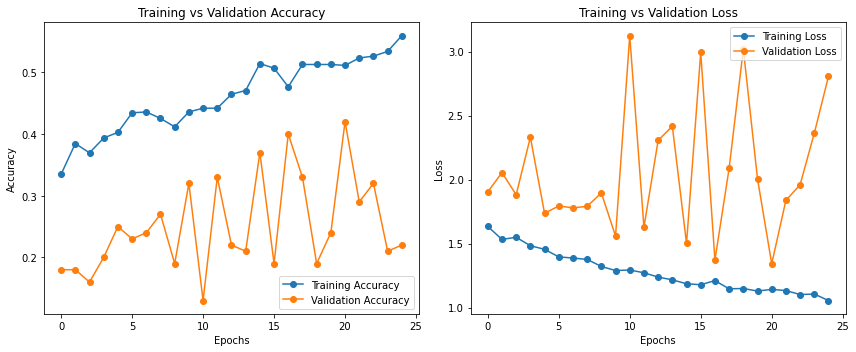

In [26]:
plot_training_history(history4)

### ___Model 5___

In [27]:
# Model Architecture
model = Sequential([
    
    # First 3D Convolutional Block
    layers.Conv3D(8, kernel_size=(5, 5, 5), activation='relu', padding='same', 
                  kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3),input_shape=input_shape),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),  # Reduce spatial dimensions

    # Second 3D Convolutional Block
    layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same', 
                  kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    # Third 3D Convolutional Block
    layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', 
                  kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)),
    layers.SpatialDropout3D(0.3),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),  
    layers.BatchNormalization(),

    # Fourth 3D Convolutional Block
    layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same', 
                  kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)),
    layers.SpatialDropout3D(0.3),
    
    # **Fix: Change Pooling to (1,2,2) to avoid shrinking depth to negative**
    layers.MaxPooling3D(pool_size=(1, 2, 2)),  
    layers.BatchNormalization(),

    # Global Average Pooling instead of Flatten
    layers.GlobalAveragePooling3D(),
    
    # Fully Connected Layers
    layers.Dense(64, activation='relu', kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu', kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform'),
    
    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

# Reduce Learning Rate on Plateau
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# Print model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 120, 120, 8)   3008      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 60, 60, 16)     3472      
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 3, 30, 30, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 3, 30, 30, 32)     13856     
                                                                 
 spatial_dropout3d (SpatialD  (None, 3, 30, 30, 32)   

In [28]:
history5 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=LR, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
21/21 [==============================] - 81s 4s/step - loss: 2.3303 - categorical_accuracy: 0.1976 - val_loss: 2.4424 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - 79s 4s/step - loss: 2.0591 - categorical_accuracy: 0.2549 - val_loss: 2.1282 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - 79s 4s/step - loss: 1.9294 - categorical_accuracy: 0.3047 - val_loss: 1.8502 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 4/25
21/21 [==============================] - 75s 4s/step - loss: 1.8234 - categorical_accuracy: 0.3258 - val_loss: 1.7044 - val_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 5/25
21/21 [==============================] - 76s 4s/step - loss: 1.7397 - categorical_accuracy: 0.3605 - val_loss: 1.5819 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 6/25
21/21 [==============================] - 83s 4s/step - loss: 1.7012 - categorical_accuracy: 0.3665 - val

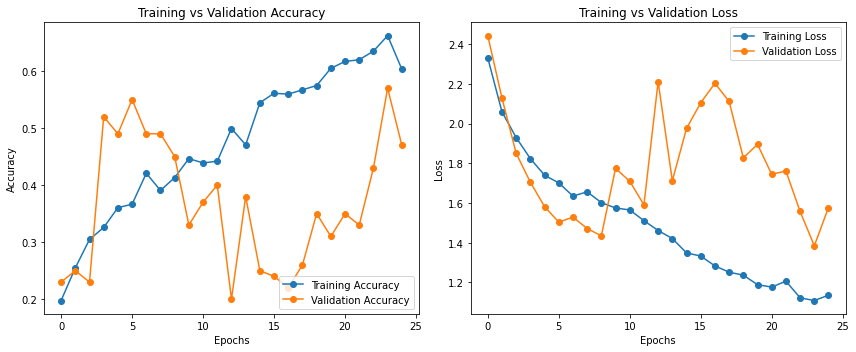

In [29]:
plot_training_history(history5)

#### **Comparison of Models and Their Performance**  

##### **1. Conv3D (Experiments 1 & 2)**
- **Best Accuracy:** *0.84 (Experiment 1), 0.79 (Experiment 2)*
- **Strengths:** *Good initial performance, strong feature extraction from spatiotemporal data.*
- **Weaknesses:** *Severe overfitting (training accuracy reaches 100%, while validation stagnates).*
- **Potential Improvements:** *Regularization (dropout, L2 penalty), data augmentation, and early stopping.*

---

#### **2. Conv3D with Regularization (Experiments 3, 4, & 5)**  

##### **Experiment 3 (L1/L2 Regularization + BatchNorm + Dropout)**
- **Accuracy:** *0.76*
- *Regularization helps with stability, but occasional loss spikes occur.*
- **Suggested improvements:** *Hyperparameter tuning for dropout rates and learning rate (LR) scheduling.*

##### **Experiment 4 (L2 Regularization + BatchNorm + Dropout + Global Average Pooling)**
- **Accuracy:** *0.52*
- *Over-regularization limits learning, leading to lower accuracy.*
- **Suggested improvements:** *Adjust dropout rates, increase model complexity, or try different augmentation strategies.*

##### **Experiment 5 (L2 Regularization + BatchNorm + Spatial Dropout + Global Average Pooling)**
- **Accuracy:** *0.47*
- *Performance fluctuates, and over-regularization seems to hinder learning.*
- **Suggested improvements:** *Reduce dropout rates, modify pooling strategies.*

> *🔹 Takeaway:* *Adding regularization improves training stability but can lead to underfitting if not carefully tuned.*

---

### ___Model 6___

In [30]:
# Build the 3D CNN + LSTM Model
model = Sequential([
    # 3D CNN Feature Extractor
    Conv3D(8, kernel_size=(3,3,3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=(1,2,2)),
    
    Conv3D(16, kernel_size=(3,3,3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(1,2,2)),
    
    Conv3D(32, kernel_size=(3,3,3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(1,2,2)),
    BatchNormalization(),
    Dropout(0.2),
    
    # Convert 3D features to a sequence for LSTM
    TimeDistributed(Flatten()),  # Flattens each frame separately

    # GRU for Temporal Dependencies
    GRU(64, return_sequences=False),  # If stacking LSTMs, use return_sequences=True
    Dropout(0.5),

    # Fully Connected Layers
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the Model
model.compile(
    optimizer='Adam',  
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

# Print Model Summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 15, 120, 120, 8)   656       
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 60, 60, 16)    3472      
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 15, 30, 30, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 15, 30, 30, 32)    13856     
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 15, 15, 15, 32)  

In [31]:
history6 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=LR, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
21/21 [==============================] - 81s 4s/step - loss: 1.8194 - categorical_accuracy: 0.2655 - val_loss: 1.8204 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - 78s 4s/step - loss: 1.6120 - categorical_accuracy: 0.3047 - val_loss: 1.9455 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - 76s 4s/step - loss: 1.4746 - categorical_accuracy: 0.3741 - val_loss: 1.7823 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 4/25
21/21 [==============================] - 79s 4s/step - loss: 1.3854 - categorical_accuracy: 0.4118 - val_loss: 1.9732 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 5/25
21/21 [==============================] - 75s 4s/step - loss: 1.3079 - categorical_accuracy: 0.4103 - val_loss: 1.7494 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 6/25
21/21 [==============================] - 79s 4s/step - loss: 1.2505 - categorical_accuracy: 0.4691 - val

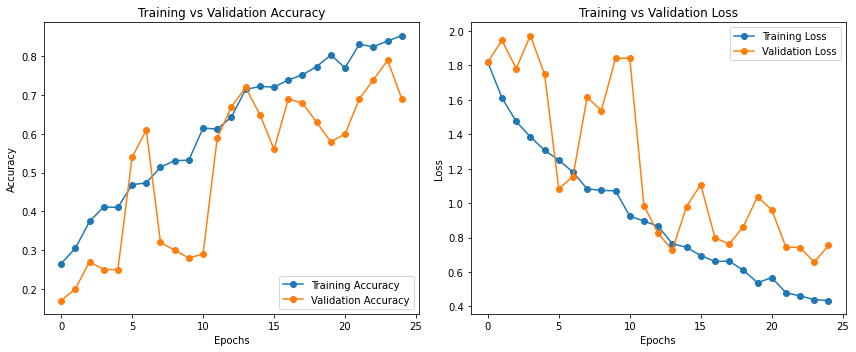

In [32]:
plot_training_history(history6)

### ___Model 7___

In [33]:
model = Sequential([
        TimeDistributed(Conv2D(8, 3, activation='relu', input_shape=input_shape,padding='same')),
        TimeDistributed(MaxPooling2D()),
        TimeDistributed(Dropout(0.3)),

        TimeDistributed(Conv2D(16, 3, activation='relu', padding='same')),
        TimeDistributed(MaxPooling2D()),
        TimeDistributed(Dropout(0.3)),

        TimeDistributed(Conv2D(32, 3, activation='relu', padding='same')),
        TimeDistributed(MaxPooling2D()),
        TimeDistributed(Dropout(0.3)),

        TimeDistributed(Conv2D(64, 3, activation='relu', padding='same')),
        TimeDistributed(MaxPooling2D()),
        TimeDistributed(Dropout(0.3)),

        TimeDistributed(Flatten()),
        LSTM(32),
        Dense(num_classes, activation='softmax'),
    ])

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
history7 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=LR, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
21/21 [==============================] - 84s 4s/step - loss: 1.6421 - accuracy: 0.2157 - val_loss: 1.5903 - val_accuracy: 0.2700 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - 75s 4s/step - loss: 1.5694 - accuracy: 0.2775 - val_loss: 1.6056 - val_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - 80s 4s/step - loss: 1.5183 - accuracy: 0.3183 - val_loss: 1.5722 - val_accuracy: 0.2400 - lr: 0.0010
Epoch 4/25
21/21 [==============================] - 78s 4s/step - loss: 1.4369 - accuracy: 0.3725 - val_loss: 1.5077 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 5/25
21/21 [==============================] - 79s 4s/step - loss: 1.2968 - accuracy: 0.4751 - val_loss: 1.4511 - val_accuracy: 0.3200 - lr: 0.0010
Epoch 6/25
21/21 [==============================] - 72s 4s/step - loss: 1.2680 - accuracy: 0.4811 - val_loss: 1.2956 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 7/25
21/21 [==============================] - 75s 4s/step - loss: 1.1499 - a

In [36]:
print(history7.history.keys())  # Check available keys

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


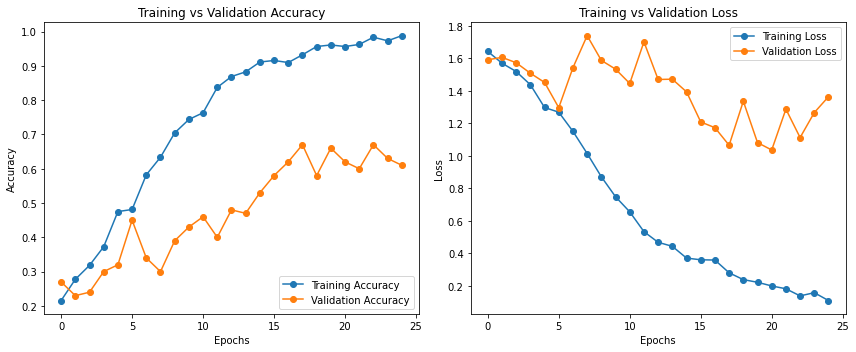

In [37]:
    acc = history7.history.get('accuracy', [])
    val_acc = history7.history.get('val_accuracy', [])
    loss = history7.history.get('loss', [])
    val_loss = history7.history.get('val_loss', [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training vs Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training vs Validation Loss')

    plt.tight_layout()
    plt.show()

### ___Model 8___

In [38]:
 model = tf.keras.Sequential([
     
        ConvLSTM2D(8, 3, activation='tanh', input_shape=input_shape,return_sequences=True, data_format='channels_last', recurrent_dropout=0.3),
        MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'),
        TimeDistributed(Dropout(0.3)),
    
        ConvLSTM2D(8, 3, activation='tanh', return_sequences=True,data_format='channels_last', recurrent_dropout=0.3),
        MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'),
        TimeDistributed(Dropout(0.3)),
    
        ConvLSTM2D(16, 3, activation='tanh', return_sequences=True,data_format='channels_last', recurrent_dropout=0.3),
        MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'),
        TimeDistributed(Dropout(0.3)),
    
        ConvLSTM2D(32, 3, activation='tanh', return_sequences=True,data_format='channels_last', recurrent_dropout=0.3),
        MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'),
        TimeDistributed(Dropout(0.3)),
    
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(num_classes, activation='softmax'),
    ])

In [39]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
history8 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=LR, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
21/21 [==============================] - 87s 4s/step - loss: 1.6141 - accuracy: 0.1991 - val_loss: 1.6047 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - 76s 4s/step - loss: 1.6105 - accuracy: 0.2021 - val_loss: 1.6080 - val_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - 81s 4s/step - loss: 1.6092 - accuracy: 0.2142 - val_loss: 1.6047 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 4/25
21/21 [==============================] - 84s 4s/step - loss: 1.5528 - accuracy: 0.2956 - val_loss: 1.5465 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 5/25
21/21 [==============================] - 78s 4s/step - loss: 1.5285 - accuracy: 0.3062 - val_loss: 1.4514 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 6/25
21/21 [==============================] - 80s 4s/step - loss: 1.3735 - accuracy: 0.4103 - val_loss: 1.9550 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 7/25
21/21 [==============================] - 80s 4s/step - loss: 1.2706 - a

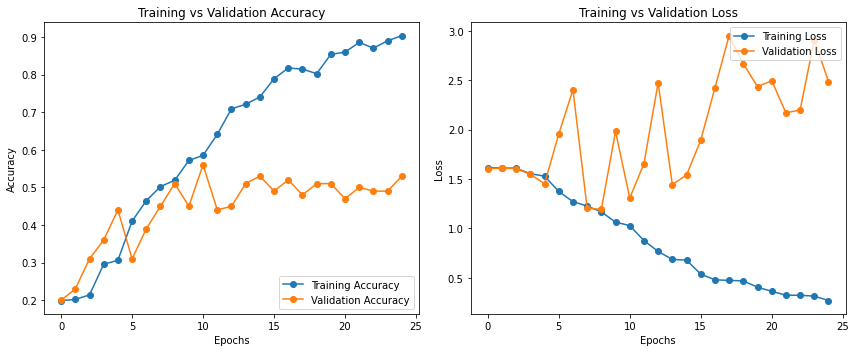

In [ ]:
    acc = history8.history.get('accuracy', [])
    val_acc = history8.history.get('val_accuracy', [])
    loss = history8.history.get('loss', [])
    val_loss = history8.history.get('val_loss', [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training vs Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training vs Validation Loss')

    plt.tight_layout()
    plt.show()

#### **Comparison of Models and Their Performance**  

##### **3. Hybrid Models (Experiments 6, 7 & 8)**  

##### **Experiment 6 (Conv3D + GRU)**
- **Accuracy:** *0.74*
- *Benefits from GRU's temporal modeling, improving sequence learning.*
- **Issues:** *Initial training instability, validation loss fluctuation.*
- **Suggested improvements:** *Fine-tune GRU layers, add attention mechanisms, adjust dropout and LR.*

##### **Experiment 7 (TimeDistributed Conv2D + LSTM)**
- **Accuracy:** *0.59*
- *Learns temporal features but suffers from overfitting (training accuracy reaches 99%).*
- **Suggested improvements:** *BatchNorm, tuning dropout, switching LSTM to BiLSTM.*

##### **Experiment 8 (ConvLSTM2D + Dropout + MaxPooling3D)**
- **Accuracy:** *0.56*
- *Good at capturing spatiotemporal dependencies, but training is unstable.*
- **Issues:** *Loss fluctuations and overfitting.*
- **Suggested improvements:** *Increase dataset size, add recurrent dropout, integrate attention mechanisms.*

> *🔹 Takeaway:* *Hybrid models help capture spatiotemporal features but need additional fine-tuning for stability.*

---

#### **Final Observations**
- **Best Model:** *Conv3D (Experiment 1, Accuracy: 0.84), but it suffers from overfitting.*
- **Regularization Helps but Can Lead to Underfitting:** *Experiment 3 performed well with regularization, but Experiments 4 & 5 showed lower accuracy due to excessive constraints.*
- **Hybrid Models Show Potential:** *Experiment 6 (Conv3D + GRU) performed well, but further improvements (e.g., attention mechanisms) are needed for stability.*
- **Main Issues Across Models:** *Overfitting in simple Conv3D models, instability in hybrid models, and underfitting when too much regularization is applied.*

---


## Final Model

In [26]:
model = Sequential([
    Input(shape=input_shape),  # (frames, height, width, channels)

    # 1st Conv3D Layer
    Conv3D(8, (3,3,3), activation='relu', padding='same'),
    MaxPooling3D((2,2,2)),

    # 2nd Conv3D Layer
    Conv3D(16, (3,3,3), activation='relu', padding='same'),
    MaxPooling3D((2,2,2)),
    Dropout(0.2),

    # 3rd Conv3D Layer
    Conv3D(32, (3,3,3), activation='relu', padding='same',kernel_regularizer=l2(0.001)),
    MaxPooling3D((2,2,1)),  # Reduce spatial dimensions while preserving temporal depth
    Dropout(0.3),

    # Fully Connected Layers
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')  # 5 classes for gesture classification
])

optimizer = Adam(learning_rate=0.0001)  # Initial LR

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 120, 120, 8)   656       
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 60, 60, 8)     0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 60, 60, 16)     3472      
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 3, 30, 30, 16)    0         
 3D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 3, 30, 30, 16)     0         
                                                                 
 conv3d_8 (Conv3D)           (None, 3, 30, 30, 32)    

In [30]:
history10 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6468 - categorical_accuracy: 0.1931Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-03-1214_29_21.921535/model-00001-1.64677-0.19306-1.61695-0.23000.h5
21/21 [==============================] - 80s 4s/step - loss: 1.6468 - categorical_accuracy: 0.1931 - val_loss: 1.6170 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6184 - categorical_accuracy: 0.2187
Epoch 00002: saving model to model_init_2025-03-1214_29_21.921535/model-00002-1.61837-0.21870-1.61543-0.24000.h5
21/21 [==============================] - 76s 4s/step - loss: 1.6184 - categorical_accuracy: 0.2187 - val_loss: 1.6154 - val_categorical_accuracy: 0.2400 - lr: 1.0000e-04
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.5974 - categorical_accuracy: 0.2609
Epoch 00003: saving model to model_init_2025-03-1214_29_2

In [ ]:
plot_training_history(history10)

NameError: name 'plot_training_history' is not defined